In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import keras
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.applications import ResNet50,EfficientNetB0
from keras._tf_keras.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras._tf_keras.keras.models import Model
import random
import cv2
from keras._tf_keras.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.preprocessing import LabelEncoder
from keras._tf_keras.keras.utils import to_categorical
from keras._tf_keras.keras.regularizers import l2
l2_lambda=0.01

# **Load Data**

In [2]:
data_path='F:/Machine learning/Skin-Disease/train'

In [3]:
train='F:/Machine learning/Skin-Disease/train'
val='F:/Machine learning/Skin-Disease/test'


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


In [6]:
train_data = []
val_data = []

for folder in os.listdir(train):
    folder_path = os.path.join(train, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

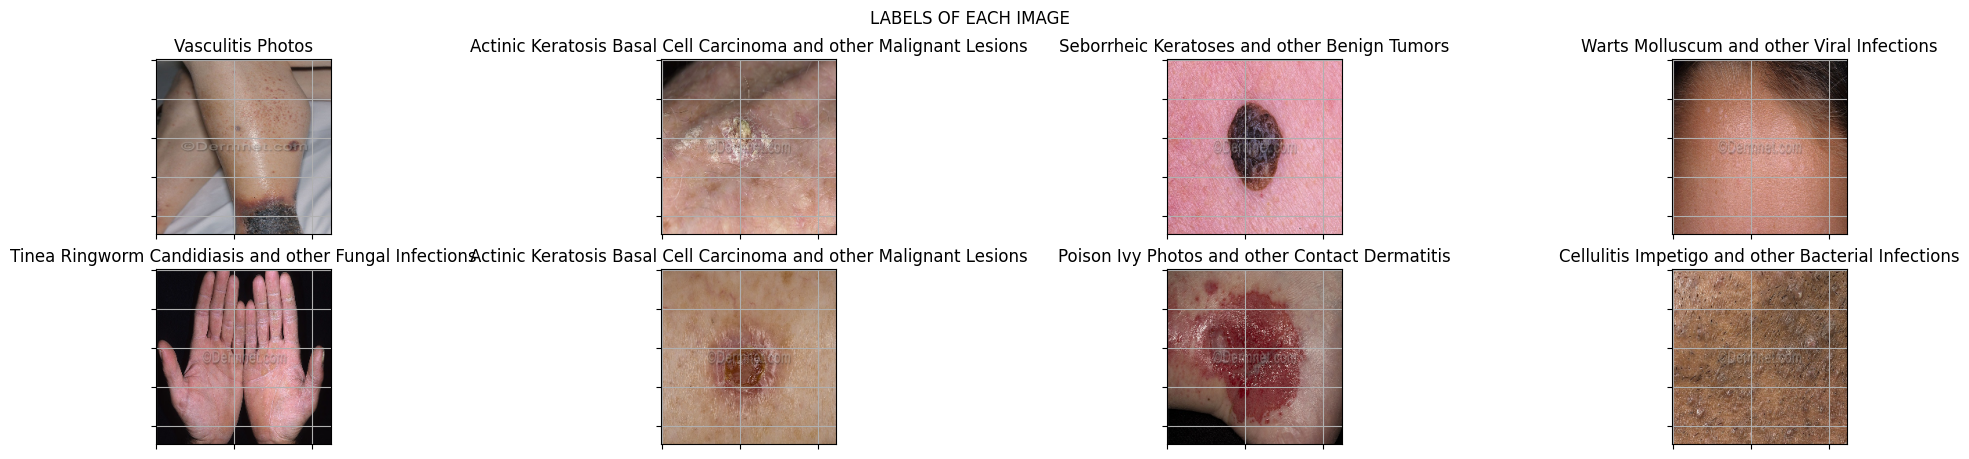

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(25, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

# Pre-Process Data

In [8]:

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, 23)
y_val_one_hot = to_categorical(y_val_encoded, 23)
np.save('label_classes.npy', le.classes_)

In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, add, Activation

def se_block(input_tensor, reduction=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // reduction, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='softmax', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input_tensor, se])
    return se

# Build Model

In [10]:
num_classes = 23
image_resize = 224
EPOCHS=60
Batch_size=20
input_shape = (image_resize, image_resize, 3)

In [11]:
resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
efficientnet_base = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

In [12]:

input_layer = keras.Input(shape=input_shape)

resnet_output = resnet_base(input_layer)
efficientnet_output = efficientnet_base(input_layer)
resnet_output_se = se_block(resnet_output)
efficientnet_output_se = se_block(efficientnet_output)
resnet_gap = layers.GlobalAveragePooling2D()(resnet_output_se)

efficientnet_gap = layers.GlobalAveragePooling2D()(efficientnet_output_se)

# Concatenate 
combined_output = layers.Concatenate()([resnet_gap, efficientnet_gap])
combined_output = layers.Dropout(0.5)(combined_output)
dense_layer = layers.Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_lambda), use_bias=False)(combined_output)
output_layer = layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal',kernel_regularizer=l2(l2_lambda), use_bias=False)(dense_layer)

In [13]:
ensemble_model = Model(inputs=input_layer, outputs=output_layer)
ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [15]:
history=ensemble_model.fit(
    X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=Batch_size
)

# Print the model summary to check the structure
ensemble_model.summary()
ensemble_model.save('my_skinmodel.h5')

Epoch 1/60
 26/622 ━━━━━━━━━━━━━━━━━━━━ 50:08 5s/step - accuracy: 0.0699 - loss: 7.0906

KeyboardInterrupt: 

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [ ]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']


epochs = range(1, len(train_loss) + 1)


plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()


plt.show()

# PREDICT

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
test_path = val

In [ ]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  

        predictions = ensemble_model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)

In [ ]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
le=LabelEncoder()
le.classes_ = np.load('label_classes.npy', allow_pickle=True)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2

test_dir = '/kaggle/input/dermnet/test'
img_height, img_width = 224, 224  # Adjust based on your model's requirements

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_height, img_width))
    img = preprocess_input(img)  # Use the appropriate preprocessing function
    return np.expand_dims(img, axis=0)

# Load all test images
test_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def predict_and_evaluate(test_images, model):
    predictions = []
    for image_path in test_images:
        img = load_and_preprocess_image(image_path)
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        predictions.append(predicted_class)
    return predictions

In [ ]:
prediction=predict_and_evaluate(test_images,ensemble_model )
predicted_class_index = np.argmax(predictions)

In [ ]:
predicted_class = le.classes_[predicted_class_index]

print(f'The predicted class for the given image is: {predicted_class}')